# Introduction to Jupyter Notebooks on Google Colab
## A tool for metabolomics data science

This is the first of two notebooks. It focuses on common tasks for exploring raw metabolomics data prior to processing, including plotting base peak chromatograms (BPCs), total ion chromatograms (TICs), boxplots of summed scan intensities, heatmaps of sample similarity, and extracted ion chromatograms (EICs) of metabolites known to be found in the data. These visualizations help assess the quality of the collected data and identify outlier or low-quality samples that may need to be removed before downstream analysis.

## Notebook setup

This notebook is designed to run in Google Colab, which comes pre-installed with several core Python libraries such as NumPy, pandas, matplotlib, and seaborn - so minimal setup is needed to get started. In the code box below, we will install the **asari-metabolomics** library, which bundles classic metabolomics tools including **pymzml** and **mass2chem**. Note the exclamation mark at the beginning of the **pip** command - it tells the Jupyter notebook to run the line as a shell command.

In [61]:
!pip3 install asari-metabolomics

import pymzml
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import requests, zipfile, io

## Data download

Next, we'll download the raw **.mzML** files from our GitHub repository to begin exploring data quality through simple summary statistics and visualizations.

In [62]:
# download raw data

# GitHub API URL of mzMLs
api_url = "https://api.github.com/repos/shuzhao-li-lab/2025_DataScience/contents/data"
download_dir = "./Datasets"

os.makedirs(download_dir, exist_ok=True)

# Get file list in the folder
response = requests.get(api_url)
if response.status_code != 200:
    raise Exception(f"Failed to fetch contents: {response.status_code}")

files = response.json()

# Loop through and download each file
for file_info in files:
    if file_info["type"] == "file":
        download_url = file_info["download_url"]
        filename = file_info["name"]
        print(f"Downloading {filename}...")

        file_response = requests.get(download_url)
        with open(os.path.join(download_dir, filename), "wb") as f:
            f.write(file_response.content)

In [63]:
# for this example, lets look at the mzML files which are a set of acquisitions collected on human plasma.
# put all mzML files in a list
file_list = glob.glob("./Datasets/*.mzML")
print(file_list)

['./Datasets/MT_20210726_009.mzML', './Datasets/MT_20210726_010.mzML', './Datasets/MT_20210726_005.mzML', './Datasets/MT_20210726_007.mzML', './Datasets/MT_20210726_011.mzML', './Datasets/Blank_20210726_003.mzML', './Datasets/MT_20210726_013.mzML', './Datasets/MT_20210726_003.mzML', './Datasets/MT_20210726_001.mzML', './Datasets/MT_20210726_015.mzML', './Datasets/MT_20210726_019.mzML']


In [64]:
# Let's look at the metadata to see what we are dealing with
meta = pd.read_csv('./Datasets/hilic_pos_metadata.csv')
meta['Sample'] = meta['file_name'].astype(str) + '.mzML'
meta = meta.drop(['path', 'process_method', 'position', 'new_name', 'instrument_method'], axis=1)
display(meta)

,sample_type,file_name,sample_id,batch,comment,inj_vol,Sample
0,QC,MT_20210726_001,Qstd_20210726_1_001,1,1,2,MT_20210726_001.mzML
1,QC,MT_20210726_003,Qstd_20210726_1_003,1,1,2,MT_20210726_003.mzML
2,QC,MT_20210726_005,Qstd_20210726_1_005,1,1,2,MT_20210726_005.mzML
3,QC,MT_20210726_007,Qstd_20210726_1_007,2,1,2,MT_20210726_007.mzML
4,QC,MT_20210726_009,Qstd_20210726_1_009,2,1,2,MT_20210726_009.mzML
5,QC,MT_20210726_010,Qstd_20210726_1_010,2,1,2,MT_20210726_010.mzML
6,QC,MT_20210726_013,Qstd_20210726_1_013,3,1,2,MT_20210726_013.mzML
7,QC,MT_20210726_015,Qstd_20210726_1_015,3,1,2,MT_20210726_015.mzML
8,QC,MT_20210726_019,Qstd_20210726_1_019,3,1,2,MT_20210726_019.mzML
9,QC,MT_20210726_011,Qstd_DDA_20210726_1_001,1,1,2,MT_20210726_011.mzML


### Summary Metrics

A simple first check is to look at the file size. This indicates whether files are corrupt or empty.

In [65]:
from IPython.display import display

data = []
for f in file_list:
    try:
        size_bytes = os.path.getsize(f)
        size_mb = size_bytes / (1024 * 1024)  # convert to MB
        data.append({
            'File Name': os.path.basename(f),
            'Size (MB)': f"{size_mb:.2f}"
        })
    except FileNotFoundError:
        data.append({
            'File Name': os.path.basename(f),
            'Size (MB)': 'File not found'
        })

df_sizes = pd.DataFrame(data).sort_values(by='File Name')
display(df_sizes)

,File Name,Size (MB)
5,Blank_20210726_003.mzML,11.42
8,MT_20210726_001.mzML,9.82
7,MT_20210726_003.mzML,9.82
2,MT_20210726_005.mzML,9.91
3,MT_20210726_007.mzML,10.01
0,MT_20210726_009.mzML,10.04
1,MT_20210726_010.mzML,16.93
4,MT_20210726_011.mzML,18.06
6,MT_20210726_013.mzML,10.14
9,MT_20210726_015.mzML,9.94


Next, we will look at the retention time range (start and end time in minutes) of all samples. This checks that acquistion time windows are consistent.

,Sample,RT_min,RT_max,RT_range
5,Blank_20210726_003.mzML,0.008650,4.998629,4.989979
8,MT_20210726_001.mzML,0.006466,4.999850,4.993384
7,MT_20210726_003.mzML,0.008618,4.996449,4.987832
2,MT_20210726_005.mzML,0.008655,4.996790,4.988134
3,MT_20210726_007.mzML,0.008648,4.998599,4.989951
0,MT_20210726_009.mzML,0.008588,4.996085,4.987497
1,MT_20210726_010.mzML,0.011466,4.997172,4.985706
4,MT_20210726_011.mzML,0.008665,4.985207,4.976542
6,MT_20210726_013.mzML,0.006473,4.993789,4.987317
9,MT_20210726_015.mzML,0.008605,4.999664,4.991059


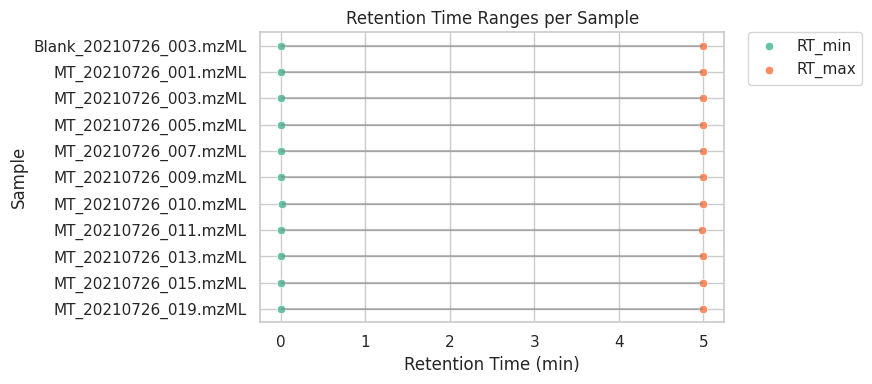

In [66]:
rt_ranges = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)

    rt_values = []
    for spectrum in run:
        if spectrum.ms_level == 1:
            try:
                rt = spectrum.scan_time_in_minutes()
            except:
                rt = spectrum.scan_time
            rt_values.append(rt)

    if rt_values:
        rt_min = min(rt_values)
        rt_max = max(rt_values)
        rt_ranges.append({
            'Sample': sample_name,
            'RT_min': rt_min,
            'RT_max': rt_max,
            'RT_range': rt_max - rt_min
        })

df_rt_ranges = pd.DataFrame(rt_ranges).sort_values('Sample')
display(df_rt_ranges)

plt.figure(figsize=(9, 4))

# Plot points at RT_min and RT_max
palette = sns.color_palette("Set2", 2)

sns.scatterplot(x='RT_min', y='Sample', data=df_rt_ranges, label='RT_min', color=palette[0])
sns.scatterplot(x='RT_max', y='Sample', data=df_rt_ranges, label='RT_max', color=palette[1])

# Draw horizontal lines to show ranges
for idx, row in df_rt_ranges.iterrows():
    plt.hlines(
        y=row['Sample'],
        xmin=row['RT_min'],
        xmax=row['RT_max'],
        color='gray',
        alpha=0.5
    )

plt.xlabel('Retention Time (min)')
plt.ylabel('Sample')
plt.title('Retention Time Ranges per Sample')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### TIC and BPC

In this code chunk, we will first extract the intensities per scan across each file. TICs and BPCs are similar, in that it plots scan intensities across runtime (RT). However, the metrics differ in how they use the intensities. In a TIC, the intensities are summed across all mass spectral peaks for each scan, whereas for a BPC, the most abundant ion per scan is kept. Both can be used to identify samples with abnormally low or noisy signal.


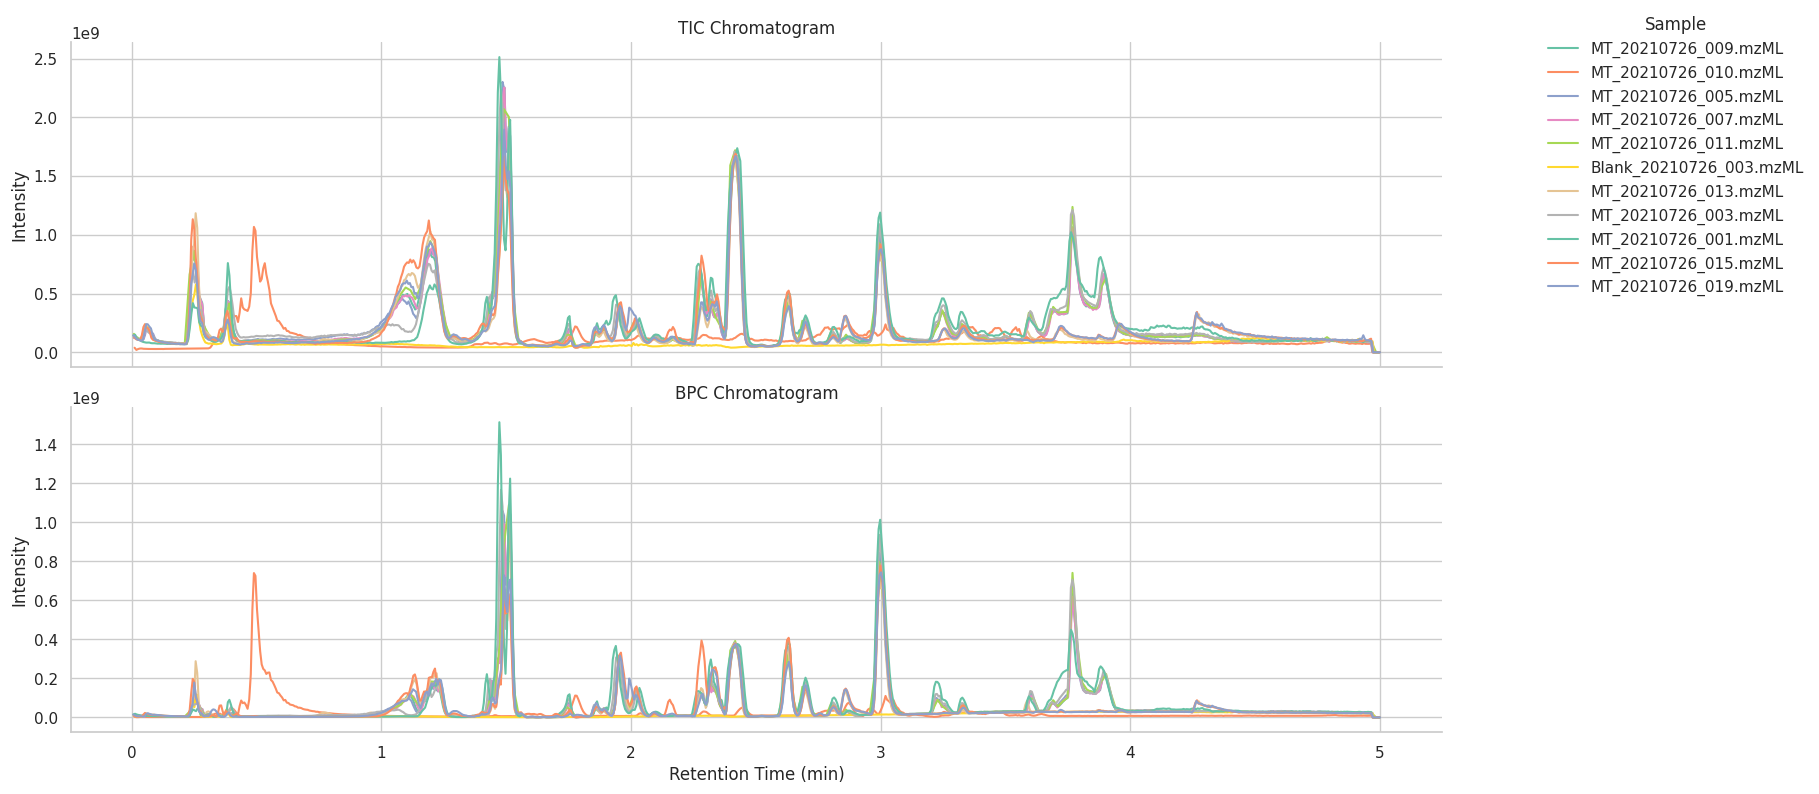

In [67]:
# Prepare lists to collect data
data = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)

    for spectrum in run:
        try:
            ms_level = int(spectrum.ms_level)
        except Exception:
            continue  # skip invalid

        if ms_level == 1:
            try:
                scan_time = spectrum.scan_time_in_minutes()
            except:
                scan_time = spectrum.scan_time  # fallback

            intensities = spectrum.i
            tic = sum(intensities)
            bpc = max(intensities)

            # Append both TIC and BPC as separate rows for faceting
            data.append({
                "Sample": sample_name,
                "RetentionTime": scan_time,
                "Intensity": tic,
                "Chromatogram": "TIC"
            })
            data.append({
                "Sample": sample_name,
                "RetentionTime": scan_time,
                "Intensity": bpc,
                "Chromatogram": "BPC"
            })

# Create a DataFrame
df = pd.DataFrame(data)

# Set seaborn style
sns.set(style="whitegrid")

# Create a FacetGrid: one row per chromatogram type
g = sns.FacetGrid(df, row="Chromatogram", height=4, sharex=True, sharey=False, aspect=3)

# Map lineplot to each facet
g.map_dataframe(sns.lineplot, x="RetentionTime", y="Intensity", hue="Sample", palette="Set2")

# Adjust legend outside
g.add_legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left')

# Axis labels and titles
g.set_axis_labels("Retention Time (min)", "Intensity")
g.set_titles("{row_name} Chromatogram")

plt.tight_layout()
plt.show()


### Sample similarity

Next, we will plot a heatmap of the simlarity between samples based on their TIC. This highlights clusters of samples with similar signal profiles, so can reveal batch effects (are samples from batch 1 and batch 2 extremelty different?) and helps to show outlier samples with distinct chromatographic profiles.

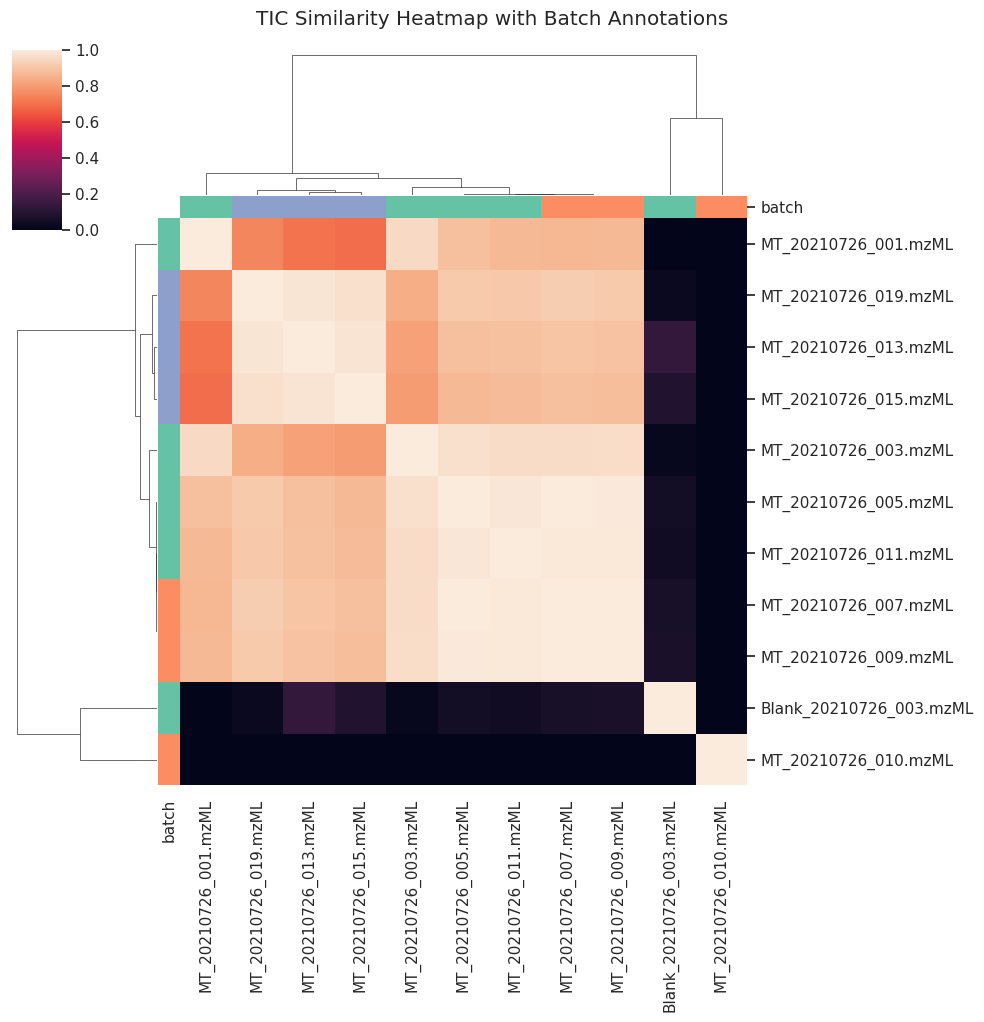

In [75]:
from scipy.interpolate import interp1d

# 1. Filter only TIC rows
df_tic = df[df['Chromatogram'] == 'TIC'].copy()

# 2. Pivot to wide format: index = RT, columns = Sample, values = Intensity
df_pivot = df_tic.pivot(index='RetentionTime', columns='Sample', values='Intensity')

# 3. Interpolate each sample to a common retention time grid
rt_common = np.linspace(df_pivot.index.min(), df_pivot.index.max(), 1000)
df_interp = pd.DataFrame(index=rt_common)

for sample in df_pivot.columns:
    # Drop NaNs for interpolation
    valid = df_pivot[sample].dropna()
    f = interp1d(valid.index, valid.values, bounds_error=False, fill_value=0)
    df_interp[sample] = f(rt_common)

# 4. Compute Pearson correlation matrix
corr_matrix = df_interp.corr(method='pearson')

# 5. Load metadata with sample → batch mapping
meta = meta.set_index('Sample').loc[corr_matrix.index]  # match order

# 6. Assign a color to each batch
batch_palette = sns.color_palette("Set2", n_colors=meta['batch'].nunique())
batch_lut = dict(zip(meta['batch'].unique(), batch_palette))
batch_colors = meta['batch'].map(batch_lut)

# 7. Plot cluster heatmap with batch color bars
sns.clustermap(
    corr_matrix,
    row_colors=batch_colors,
    col_colors=batch_colors,
    cmap='rocket',
    vmin=0,
    vmax=1,
    figsize=(10, 10)
)

plt.suptitle("TIC Similarity Heatmap with Batch Annotations",
             y=1.02)
plt.show()

### Scan Count

Next, we will make a barplot of the total number of scans per sample. Inconsistent scan counts may indicate there were acquistion errors.

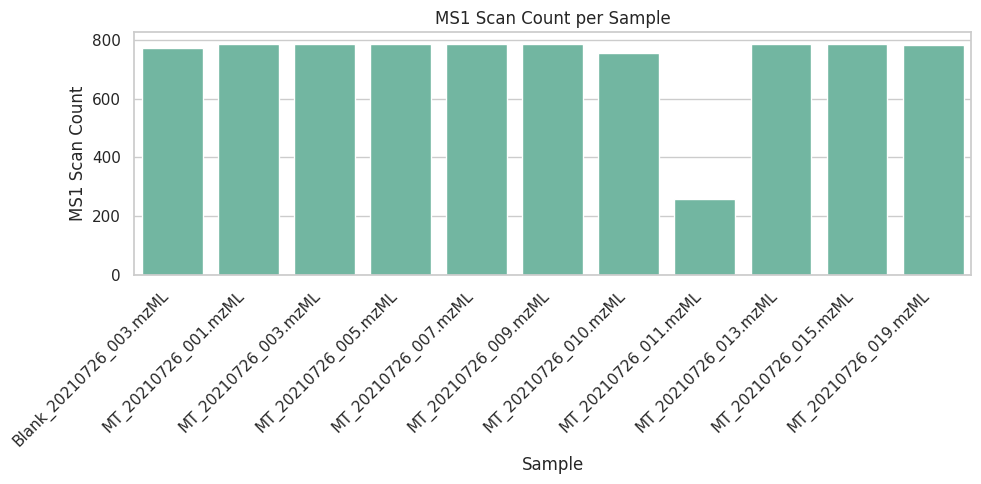

In [69]:
# --- Count MS1 scans per file ---
scan_counts = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)
    count = sum(1 for spec in run if spec.ms_level == 1)
    scan_counts.append({'Sample': sample_name, 'MS1_ScanCount': count})

# --- Convert to DataFrame ---
df_scans = pd.DataFrame(scan_counts).sort_values('Sample')

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df_scans, x='Sample', y='MS1_ScanCount', color=palette[0])
plt.xticks(rotation=45, ha='right')
plt.ylabel('MS1 Scan Count')
plt.title('MS1 Scan Count per Sample')
plt.tight_layout()
plt.show()

### Summed Intensity

In this next section, we will plot a boxplot of summed ion intensities per scan, per file. This can be used to evaluate overall signal abundance.

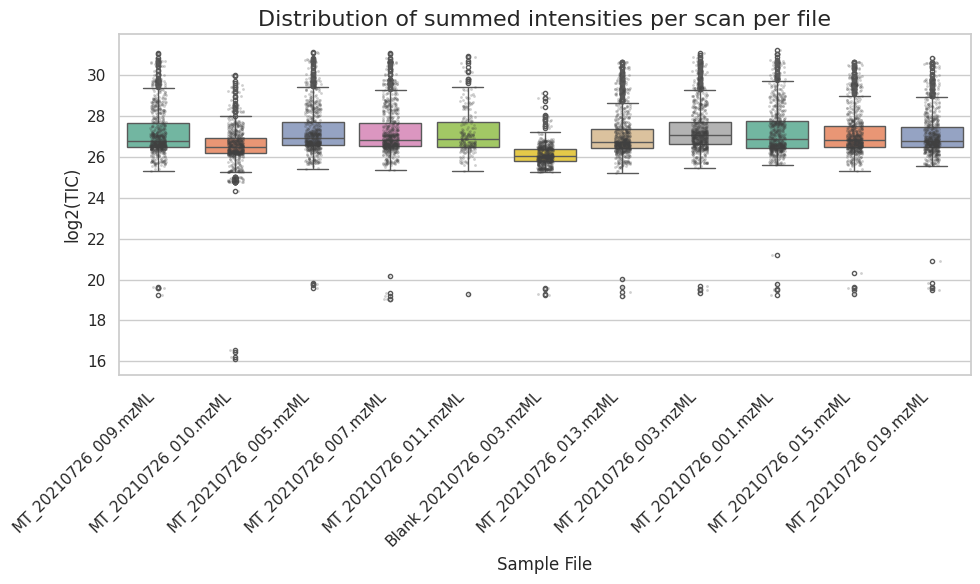

In [70]:
tic_data = []
labels = []

# Prepare data in long format for seaborn
data = {
    'File': [],
    'log2_TIC': []
}

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    label = os.path.basename(file_path)

    for spectrum in run:
        if spectrum.ms_level == 1:
            tic = sum(spectrum.i)
            log2_tic = np.log2(tic + 1e-6)
            data['File'].append(label)
            data['log2_TIC'].append(log2_tic)

df = pd.DataFrame(data)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.boxplot(x='File', y='log2_TIC', data=df, hue = "File",
                 palette="Set2", fliersize=3, legend=False)
ax = sns.stripplot(x='File', y='log2_TIC', data=df, color='0.25',
                   size=2, alpha = 0.25, jitter=True)


ax.set_title('Distribution of summed intensities per scan per file', fontsize=16)
ax.set_ylabel('log2(TIC)')
ax.set_xlabel('Sample File')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### EIC

The final task is to plot EICs, which display the intensity of a specific m/z value over time. This permits visualizing compound-specific patterns, and helps to confirm the presence of known metabolites in our data such as spike-in standards. Below, is a function to extract and plot EICs of a target metabolite.

In [71]:
def extract_and_plot_eic(file_list, mz, tolerance=0.01, min_intensity_ratio=0.01, ms_level=1):
    """
    Extracts and plots EIC (Extracted Ion Chromatograms) for a specified m/z across multiple mzML files.

    Parameters:
        file_list (list): List of mzML file paths
        mz (float): Target m/z value
        tolerance (float): ± window around the target m/z
        min_intensity_ratio (float): Minimum intensity threshold relative to max (optional, not used in filtering now)
        ms_level (int): MS level to extract from (default = 1)
    """
    data = []

    for file_path in file_list:
        run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
        sample_name = os.path.basename(file_path)
        rt = []
        intensity = []

        for spectrum in run:
            if spectrum.ms_level == ms_level:
                mz_array = spectrum.mz
                i_array = spectrum.i

                # Match peaks within tolerance window
                matched = [i for m, i in zip(mz_array, i_array) if abs(m - mz) <= tolerance]

                if matched:
                    try:
                        scan_time = spectrum.scan_time_in_minutes()
                    except:
                        scan_time = spectrum.scan_time

                    rt.append(scan_time)
                    intensity.append(sum(matched))

        # Sort by retention time
        if rt:
            rt, intensity = zip(*sorted(zip(rt, intensity)))
            for t, inten in zip(rt, intensity):
                data.append({
                    "Sample": sample_name,
                    "RetentionTime": t,
                    "Intensity": inten
                })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Plot with seaborn
    if not df.empty:
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df, x="RetentionTime", y="Intensity", hue="Sample", marker=None, palette="Set2")

        plt.xlabel("Retention Time (min)")
        plt.ylabel(f"Intensity at m/z {mz:.2f} ± {tolerance}")
        plt.title(f"Extracted Ion Chromatograms (EIC) at m/z {mz:.2f}")
        plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No matching peaks found for m/z {mz} ± {tolerance}.")



List of known compounds in our samples
*   [¹³C₃]-Caffeine - spike-in - 197.0905
*   L-Valine - common plasma metabolite -	117.0789
*   L-Phenylalanine	- common plasma metabolite -	165.0790

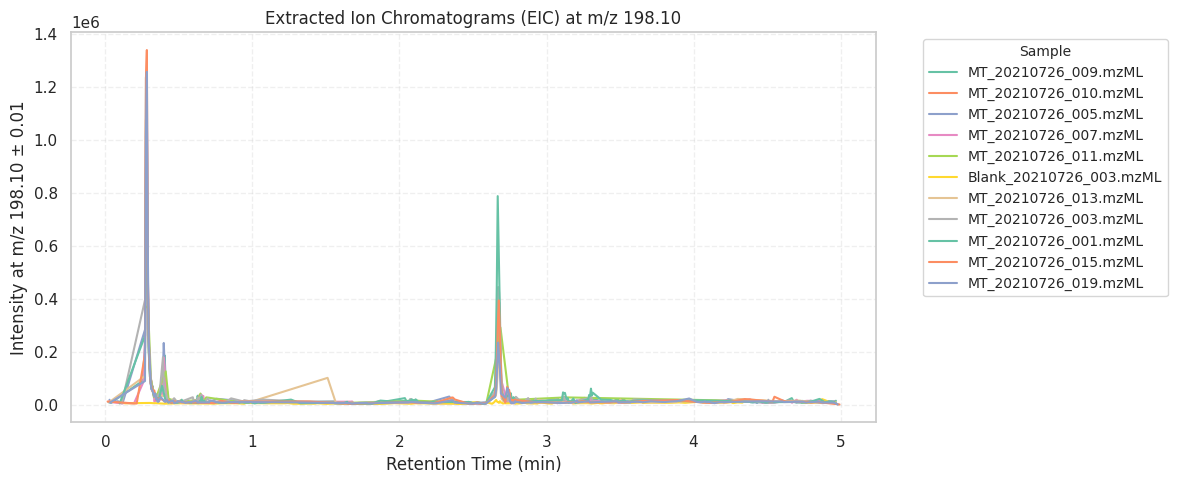

In [72]:
# [¹³C₃]-Caffeine
mol_weight = 197.0905 + 1.007276
extract_and_plot_eic(file_list, mz=mol_weight, tolerance=0.01)

# while we do see two peaks, the first peak is likely an artifact (too early, in the void volumn).
# Also the peak shape is noisy. The second peak is cleaner (low bacground noise, good Gaussian shape)
# and is well-retained (RT makes sense).

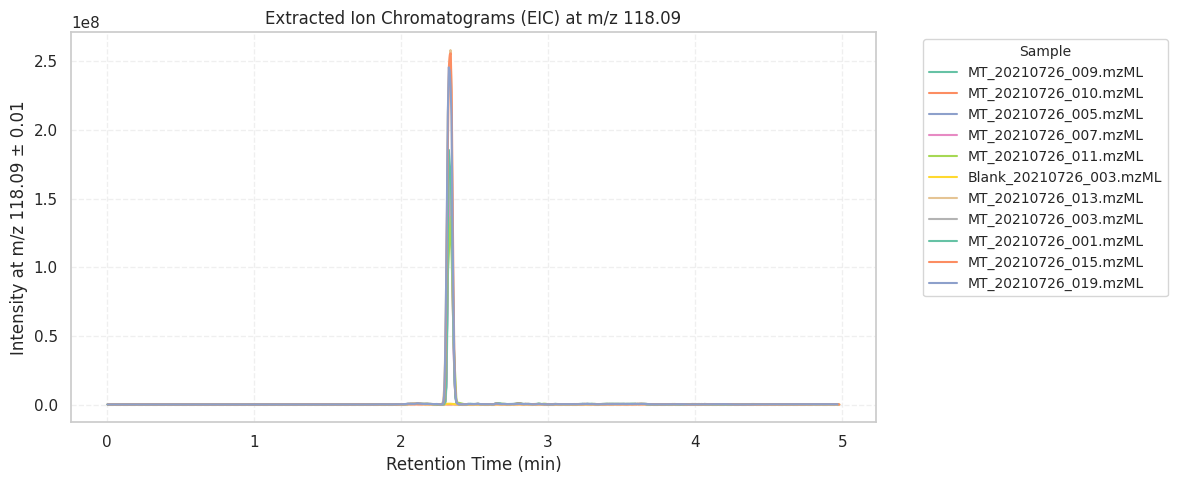

In [73]:
# L-Valine + [M+H]+ adduct because it's HILIC Pos
mol_weight = 117.0789 + 1.007276
extract_and_plot_eic(file_list, mz=mol_weight, tolerance=0.01)

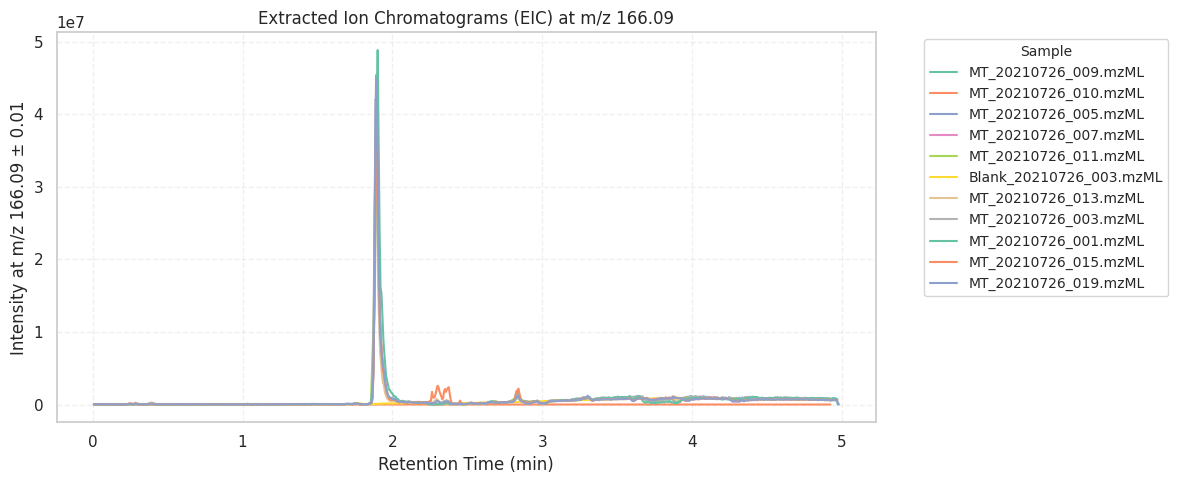

In [74]:
# L-Phenylalanine + [M+H]+ adduct because it's HILIC Pos
mol_weight = 165.0790 + 1.007276
extract_and_plot_eic(file_list, mz=mol_weight, tolerance=0.01)